In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [11]:
phrasedf = pd.read_csv('phrasedf.csv', index_col='idx')

In [12]:
#compute memorability categorisations 
def catmap(cat):
    if cat=='high':
        return 3
    else:
        if cat=='medium':
            return 2
        else:
            return 1
            

for idx, row in phrasedf.iterrows():
    phrasedf.at[idx, 'llama_co_score'] = round(catmap(row['llama_coherence_m']) * 0.4 + catmap(row['llama_coherence_g']) * 0.4 + catmap(row['llama_coherence_l']) *0.2, 3)
    phrasedf.at[idx, 'mistral_co_score'] = round(catmap(row['mistral_coherence_l']) * 0.4 + catmap(row['llama_coherence_m']) * 0.4 + catmap(row['mistral_coherence_m']) *0.2 ,3)

In [16]:
##### select a sample from llm-derived coherence scores to conduct human appraisal of coherence scoring
sampledf=phrasedf[(phrasedf['memorability']=='low') | (phrasedf['memorability']=='high')]
sampledf=sampledf[sampledf['words']>=6]

llama_sample=sampledf.groupby('llama_co_score', group_keys=False).apply(lambda x: x.sample(frac=0.2))
print(len(llama_sample))
mistral_sample=sampledf.groupby('mistral_co_score', group_keys=False).apply(lambda x: x.sample(frac=0.2)) 
print(len(mistral_sample))

60
60


/var/folders/cq/dpv74_vx6z763s2ht4_54zx1tyht7_/T/ipykernel_28904/286321465.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  llama_sample=sampledf.groupby('llama_co_score', group_keys=False).apply(lambda x: x.sample(frac=0.2))
/var/folders/cq/dpv74_vx6z763s2ht4_54zx1tyht7_/T/ipykernel_28904/286321465.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mistral_sample=sampledf.groupby('mistral_co_score', gr

In [25]:
# save the samples
#mistral_sample.to_csv("sample_mistral.csv")
#llama_sample.to_csv("sample_llama.csv")

#mistral_sample.to_json('sample_mistral.json', orient='records')#, lines=True)
#llama_sample.to_json('sample_llama.json', orient='records')#, lines=True)
#remember to manually add {"phrase": to each json for use in the app

#now read back for paper reproduction purposes:
#note the csv files in the folder are our own randomly selected sample! If you create your
#own sample, then you will also need to repeat our experiment with your own participants
#and own phrases! Thus the next section will not apply to you.

llama_sample = pd.read_csv('sample_llama.csv')
mistral_sample = pd.read_csv('sample_mistral.csv')

In [26]:
#### read human ratings after the experiment
humandf = pd.read_csv("samples-final.csv")
humandf.head(3)
print(len(humandf))

118


In [27]:
# merge human and LLM coherence ratings
joined_llama = llama_sample[['llama_prompt', 'llama_co_score','original']].set_index('llama_prompt').join(humandf[humandf['sample_set']=='llama'].set_index('prompt')) 
joined_mistral = mistral_sample[['mistral_prompt', 'mistral_co_score','original']].set_index('mistral_prompt').join(humandf[humandf['sample_set']=='mistral'].set_index('prompt')) 

print(len(joined_llama))
print(len(joined_mistral))

60
60


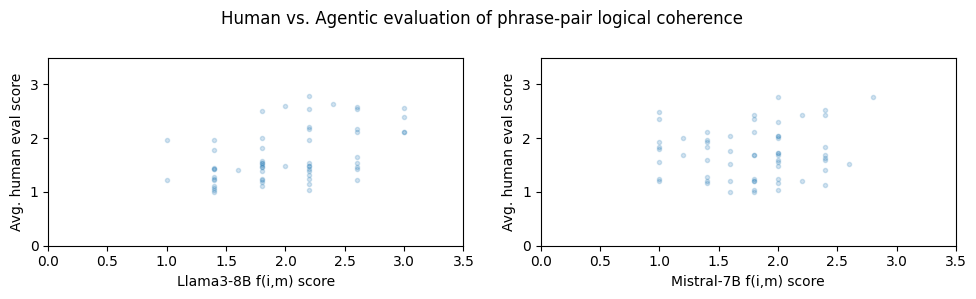

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax0, ax1=axes.flatten()
ax0.scatter(joined_llama['llama_co_score'], joined_llama['avg_coherence'], alpha=0.2, marker='.')
ax0.set_xlim(0,3.5)
ax0.set_ylim(0,3.5)

ax1.scatter(joined_mistral['mistral_co_score'], joined_mistral['avg_coherence'], alpha=0.2, marker='.')
#jitter_dots(dots,0.1)
ax1.set_xlim(0,3.5)
ax1.set_ylim(0,3.5)
ax0.set_ylabel('Avg. human eval score')
ax1.set_ylabel('Avg. human eval score')
ax0.set_xlabel('Llama3-8B f(i,m) score')
ax1.set_xlabel('Mistral-7B f(i,m) score')
fig.suptitle("Human vs. Agentic evaluation of phrase-pair logical coherence")
plt.tight_layout()
plt.show()

In [51]:
def printstat(series):
    print('mean',round(np.mean(series), 3))
    print('std',round(np.std(series), 3))
    print('min',round(np.min(series), 3))
    print('max',round(np.max(series), 3))
    print('-----')

printstat(joined_llama['avg_coherence'])
printstat(joined_llama['llama_co_score'])
printstat(joined_mistral['avg_coherence'])
printstat(joined_mistral['mistral_co_score'])


mean 1.669
std 0.494
min 1.0
max 2.786
-----
mean 1.987
std 0.516
min 1.0
max 3.0
-----
mean 1.714
std 0.467
min 1.0
max 2.76
-----
mean 1.76
std 0.47
min 1.0
max 2.8
-----


In [45]:
print(stats.normaltest(joined_llama['avg_coherence'].dropna())) #not normal
print(stats.normaltest(joined_llama['llama_co_score'].dropna())) #normal
print(stats.normaltest(joined_mistral['avg_coherence'].dropna())) #normal
print(stats.normaltest(joined_mistral['mistral_co_score'].dropna())) #normal

NormaltestResult(statistic=7.010074452006689, pvalue=0.030045654843706908)
NormaltestResult(statistic=1.8317131232352142, pvalue=0.4001737058088383)
NormaltestResult(statistic=3.4202334018457092, pvalue=0.18084468664377804)
NormaltestResult(statistic=2.900635102761974, pvalue=0.23449581180052564)


In [48]:
stats.spearmanr(joined_llama.dropna()['avg_coherence'], joined_llama.dropna()['llama_co_score'])

SignificanceResult(statistic=0.4793231215499502, pvalue=0.00012260243856553708)

In [49]:
stats.spearmanr(joined_mistral.dropna()['avg_coherence'], joined_mistral.dropna()['mistral_co_score'])

SignificanceResult(statistic=0.04047844609017002, pvalue=0.7608284045921669)